# **Second assignment: Decision trees** #

**Assigment done by Marta Longo, Lucas Oliveira, Sara Táboas for Artificial Inteligence Class**

# **Table of Contents**

<!-- Hello World -->
1. [Introduction](#Introduction)
2. [Libraries](#Libraries)
3. [ID3 Algorithm](#ID3-Algorithm)
    - [Implementation](#Implementation)

1. [Introduction](#Introduction)
1. [Introduction](#Introduction)

# Introduction 

The purpose of this assigment is to write a program that learns a decision tree from three training datasets that were given to us using the ID3 algorithm.

# Libraries
[[ go back to the top ]](#Table-of-contents)

In [34]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import math
# from imblearn.combine import SMOTEENN

# ID3 Algorithm

The ID3 algorithm is a popular method used to create decision trees, which are a type of predictive model used in machine learning and statistics. ID3 works by selecting the attribute that provides the highest information gain to split the data, aiming to reduce entropy (impurity) in the dataset. The process is repeated recursively for each subset, with the attribute that best separates the data chosen at each step, forming a tree structure where each node represents a decision based on an attribute. The recursion stops when all instances in a subset belong to the same class, no more attributes are available, or there are no more instances to split. Here are the key elements:

## **Implementation**<a id="Implementation"></a>

In [35]:
class TreeNode:
    def __init__(self, feature_index=None, value=None, label=None, counter=0, children=None, feature_name = None):
        self.feature_index = feature_index  # Index of the feature used for splitting
        self.value = value  # Value used for splitting (if categorical)
        self.label = label  # Class label (if leaf node)
        self.counter = counter  # Counter for the number of examples
        self.children = children  # Dictionary of children nodes
        self.feature_name = feature_name  #the feature that was selected
      
    
    def __str__(self):
        return ("Index: " + str(self.feature_index) + "\nValue: " + str(self.value) + "Label:" + str(self.label) + "\nChildren:" + str(self.children))
    
 
    def print_tree(self, indent="", instance_counter=None):
        if instance_counter is None:
            instance_counter = [0]  # Initialize the counter as a list to pass by reference

        instance_counter[0] += 1  # Increment the counter for each node visited
        if self.label is not None:
            return f"{indent}{self.label} ({instance_counter[0]})"
        
        result = []
        
        if isinstance(self.value, list):  # Handling categorical split
            result.append(f"\n{indent}<{self.feature_name}>")
            for v in self.value:
                child = self.children[v]
                result.append(f"\n{indent}  {v}: {child.print_tree(indent + '    ', instance_counter)}")

            # result.append(f"{indent}<{self.feature_name}>")
            # for v in self.value:
            #     child = self.children[v]
            #     result.append(f"\n{indent + '   '}  {v}:")
            #     result.append(f"{child.print_tree(indent + '    ', instance_counter)}")
        else:  # Handling numerical split
            result.append(f"{indent}<{self.feature_name}> <= {self.value}")
            result.append(f"\n{indent}  {self.children['left'].print_tree(indent + '    ', instance_counter)}")
            result.append(f"\n{indent}<{self.feature_name}> > {self.value}")
            result.append(f"\n{indent}  {self.children['right'].print_tree(indent + '    ', instance_counter)}")
        
        return "\n".join(result)
    

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def entropy(self, labels):
        # Calculate entropy (measure of impurity)
        from collections import Counter
        counts = Counter(labels)
        probabilities = [count / len(labels) for count in counts.values()]
        entropy = 0
        for p in probabilities:
            log_value = math.log2(p)
            entropy += -p * log_value
        return entropy

    def cat_information_gain(self, data, feature_index, values):
        labels = {}
        for v in values:
            labels[v] = []
        for row in data:
            for v in values:
                if row[feature_index] == v:
                    labels[v].append(row[-1])
        result = self.entropy([label for row in data for label in row[-1]])
        for v in values:
            
            result -= self.entropy(labels[v]) * len(labels[v])/len(data)
        return result

    def information_gain(self, data, feature_index, threshold):
        # Calculate information gain for a split
        left_labels, right_labels = [], []
        for row in data:
            # print(feature_index, row[feature_index], threshold)           #visualize feature index being analyzed
            if row[feature_index] <= threshold:
                left_labels.append(row[-1])
            else:
                right_labels.append(row[-1])
        parent_entropy = self.entropy([label for row in data for label in row[-1]])
        left_entropy = self.entropy(left_labels)
        right_entropy = self.entropy(right_labels)
        weight = len(left_labels) / len(data)
        return parent_entropy - (weight * left_entropy + (1 - weight) * right_entropy)

    def fit(self, data, feature_name):
        # Train the decision tree
        self.feature_name = feature_name
        self.root = self._build_tree(data, 0)
    
    def _build_tree(self, data, depth):
        # Recursive function to build the tree
        if depth >= self.max_depth or len(data) < self.min_samples_split or len(set([row[-1] for row in data])) == 1:
        # Stopping conditions: reach max depth, min samples, or pure data
            aux = majority_vote(data)
            return TreeNode(label=aux)  # Assign majority class label

        best_gain, best_feature_index, best_threshold = 0, None, None
        evaluated_data_type = None
        best_values = []
        # print("Part 1")
        for feature_index in range(len(data[0]) - 1):
            # print("Part 2")
            if type(data[1][feature_index]) != str:
                # print("NUM")
                # Find the best split among all features
                values = set([row[feature_index] for row in data])
                for value in values:
                    # print("Part 3")
                    gain = self.information_gain(data.copy(), feature_index, value)
                    if gain > best_gain:
                        # print("Part 4")
                        best_values = values.copy()
                        best_gain, best_feature_index, best_threshold = gain, feature_index, value
                        evaluated_data_type = "num"
                        # print("Best gain (num):", feature_index)
            else:
                # print("CAT")
                # print("Part 3")
                values = [item for item in set([row[feature_index] for row in data])]
                gain = self.cat_information_gain(data.copy(), feature_index, values)
                if gain > best_gain:
                    # print("Part 4")
                    best_values = values.copy()
                    best_gain, best_feature_index, best_threshold = gain, feature_index, 0
                    evaluated_data_type = "cat"
                    # print("Best gain (cat):", feature_index)
                    
        # print("USED:", best_feature_index)
        sets_of_data = {}
        children = {}
        if evaluated_data_type == "cat":
            for v in best_values:
                sets_of_data[v] = []
            for row in data:
                for v in best_values:
                    # print(row[best_feature_index], row[best_feature_index] == v)
                    if row[best_feature_index] == v:
                        sets_of_data[v].append(row)
            for v in best_values:
                # print("Data:", v)
                # print(sets_of_data[v])
                children[v] = self._build_tree(sets_of_data[v], depth + 1)
                
            return TreeNode(
                feature_index=best_feature_index,
                value=best_values,
                children=children,
                feature_name=self.feature_name[0][best_feature_index]
                
            )
        else:
            sets_of_data["left"] = []
            sets_of_data["right"] = []
            for row in data:
                if row[best_feature_index] <= best_threshold:
                    sets_of_data["left"].append(row)
                else:
                    sets_of_data["right"].append(row)
            children["left"] = self._build_tree(sets_of_data["left"], depth + 1)
            children["right"] = self._build_tree(sets_of_data["right"], depth + 1)
            return TreeNode(
                feature_index=best_feature_index,
                value=best_threshold,
                children=children,
                feature_name=self.feature_name[0][best_feature_index]
            )

    def predict(self, datapoint):
        # Predict class label for a new data point
        node = self.root
        counter = 0
        while node.label is None:
            if type(node.value) is list:
                for value in node.value:
                    if datapoint[node.feature_index] == value:
                        node = node.children[str(value)]
                        counter += 1
                        break
            else:
                if datapoint[node.feature_index] <= node.value:
                    node = node.children["left"]
                    counter += 1
                else:
                    node = node.children["right"]
                    counter += 1
        return node.label
    

    def print_tree(self):
        if self.root:
            return self.root.print_tree()
        
        return "Tree is empty."



# Helper function to find the majority class label
def majority_vote(data):
  labels = [row[-1] for row in data]
  from collections import Counter
  counts = Counter(labels)
#   print(counts.most_common(1))
  return counts.most_common(1)[0][0]

**TreeNode Class Attributes**
- **feature_index**: This is the index of the feature used to split the data at this node. It identifies which feature (among the input features) is being used to decide the split at this node. If this node is a leaf node (i.e., it does not split further), feature_index will be None.


- **value**: This is the value used for splitting the data at this node if the feature is continuous. For categorical features, this could be the category value. It represents the threshold or category against which the feature values are compared. If this node is a leaf node, value will be None.

- **label**: This is the class label that the node predicts if it is a leaf node. For non-leaf nodes, this will be None.

- **counter**: This represents the count of examples that reach this node during the tree building process.

- **children**: This is a dictionary that stores the children nodes of the current node. Each key in the dictionary represents a particular value or range of values of the feature associated with the current node. The values associated with these keys are the child nodes resulting from splitting the data based on the corresponding feature value. For categorical features, the keys represent distinct categories, while for continuous features, the keys can represent different partitions of the feature space.

- **feature_name**: This is the name/label of the feature associated with the current node.

**Decision Tree Class Attributes**
- **max_depth**: This specifies the maximum depth that the tree is allowed to grow to. If None, the tree will grow until all leaves are pure or until there are fewer than min_samples_split samples in the leaves. Limiting the depth helps in controlling overfitting.

- **min_samples_split**: This defines the minimum number of samples required to split an internal node. This parameter prevents the tree from splitting too much and helps in controlling overfitting. If the number of samples at a node is less than min_samples_split, the node will not be split further.

- **root**: This is the root node of the decision tree. It is the starting point for making predictions. Initially, this is None until the tree is fitted with data.

## **Entropy and Information Gain**

In [36]:
'''
def entropy(self, labels):
        # Calculate entropy (measure of impurity)
        from collections import Counter
        counts = Counter(labels)
        probabilities = [count / len(labels) for count in counts.values()]
        print("prob = ", probabilities) 
        # from math import log2
        entropy = 0
        for p in probabilities:
            log_value = math.log2(p)
            entropy += -p * log_value
        return entropy


def cat_information_gain(self, data, feature_index, values):
    labels = {}
    for v in values:
        labels[v] = []
    for row in data:
        for v in values:
            if row[feature_index] == v:
                labels[v].append(row[-1])
    result = self.entropy([label for row in data for label in row[-1]])
    for v in values:
        
        result -= self.entropy(labels[v]) * len(labels[v])/len(data)
    return result

    
def information_gain(self, data, feature_index, threshold):
    # Calculate information gain for a split
    left_labels, right_labels = [], []
    for row in data:
        # print(feature_index, row[feature_index], threshold)           
        if row[feature_index] <= threshold:
            left_labels.append(row[-1])
        else:
            right_labels.append(row[-1])
    parent_entropy = self.entropy([label for row in data for label in row[-1]])
    left_entropy = self.entropy(left_labels)
    right_entropy = self.entropy(right_labels)
    weight = len(left_labels) / len(data)
    return parent_entropy - (weight * left_entropy + (1 - weight) * right_entropy)
'''

'\ndef entropy(self, labels):\n        # Calculate entropy (measure of impurity)\n        from collections import Counter\n        counts = Counter(labels)\n        probabilities = [count / len(labels) for count in counts.values()]\n        print("prob = ", probabilities) \n        # from math import log2\n        entropy = 0\n        for p in probabilities:\n            log_value = math.log2(p)\n            entropy += -p * log_value\n        return entropy\n\n\ndef cat_information_gain(self, data, feature_index, values):\n    labels = {}\n    for v in values:\n        labels[v] = []\n    for row in data:\n        for v in values:\n            if row[feature_index] == v:\n                labels[v].append(row[-1])\n    result = self.entropy([label for row in data for label in row[-1]])\n    for v in values:\n        \n        result -= self.entropy(labels[v]) * len(labels[v])/len(data)\n    return result\n\n    \ndef information_gain(self, data, feature_index, threshold):\n    # Calcula

### 1. **entropy(self, labels):** To calculate the entropy of a set of labels. Entropy is a measure of the impurity or randomness in the dataset.

#### Functionality
- **Count occurrences**: Uses Counter from the collections module to count the occurrences of each unique label.
- **Calculate probabilities**: Computes the probability of each label by dividing the count of each label by the total number of labels.
- **Calculate entropy**: Uses the formula $$\text{Entropy} = -\sum(p \log_2 p)$$  where \( p \) is the probability of a label. This is summed over all unique labels.
- **Return entropy**: Returns the calculated entropy value.

### **2. cat_information_gain(self, data, feature_index, values):** To calculate the information gain for a categorical feature. Information gain measures the reduction in entropy achieved by splitting the data based on a feature.
- **Initialize labels dictionary**: Creates a dictionary labels to hold lists of class labels for each unique value of the categorical feature.
- **Distribute labels**: Iterates over the rows in the dataset and assigns the class label (last element in the row) to the appropriate list in the labels dictionary based on the feature value.
- **Calculate parent entropy**: Computes the entropy of the entire dataset's class labels using the entropy method.
- **Calculate information gain**:
  - For each unique value in the feature, calculate the entropy of the corresponding subset of labels.
  - Adjust the parent entropy by subtracting the weighted entropy of each subset (proportional to its size).
- **Return information gain**: Returns the resulting information gain.

### **3. information_gain(self, data, feature_index, threshold):** To calculate the information gain for a numerical feature based on a given threshold. This is used to evaluate the best threshold for splitting the data.

- **Initialize label lists**: Creates two lists, left_labels and right_labels, to hold class labels for the left and right subsets created by the threshold split.
- **Distribute labels**: Iterates over the rows in the dataset and assigns the class label (last element in the row) to either left_labels or right_labels based on whether the feature value is less than or equal to the threshold.
- **Calculate parent entropy**: Computes the entropy of the entire dataset's class labels using the entropy` method.
- **Calculate subset entropies**: Computes the entropy of left_labels and right_labels.
- **Calculate weighted average entropy**: Computes the weighted average of the left and right entropies based on their sizes relative to the total dataset.
- **Return information gain**: Subtracts the weighted average entropy from the parent entropy to get the information gain.

### **Summary**

- **entropy**: Calculates the entropy of a list of labels, providing a measure of impurity.
- **cat_information_gain**: Calculates the information gain for a categorical feature, assessing how much splitting the data on this feature reduces impurity.
- **information_gain**: Calculates the information gain for a numerical feature using a specific threshold, evaluating the effectiveness of this split in reducing impurity.

These functions are essential for decision tree algorithms, helping to determine the best features and thresholds for splitting the data to achieve the most significant reduction in impurity.

## **Train Data**

In [37]:
'''
def fit(self, data):
        # Train the decision tree
        self.root = self._build_tree(data, 0)
    
def _build_tree(self, data, depth):
    # print("Depth:", depth)
    # Recursive function to build the tree
    if depth >= self.max_depth or len(data) < self.min_samples_split or len(set([row[-1] for row in data])) == 1:
    # Stopping conditions: reach max depth, min samples, or pure data
        # print("Finished!")
        aux = majority_vote(data)
        # print("Label:", aux)
        return TreeNode(label=aux)  # Assign majority class label

    best_gain, best_feature_index, best_threshold = 0, None, None
    evaluated_data_type = None
    best_values = []
    # print("Part 1")
    for feature_index in range(len(data[0]) - 1):
        # print("Part 2")
        if type(data[1][feature_index]) != str:
            # print("NUM")
            # Find the best split among all features
            values = set([row[feature_index] for row in data])
            for value in values:
                # print("Part 3")
                gain = self.information_gain(data.copy(), feature_index, value)
                if gain > best_gain:
                    # print("Part 4")
                    best_values = values.copy()
                    best_gain, best_feature_index, best_threshold = gain, feature_index, value
                    evaluated_data_type = "num"
                    # print("Best gain (num):", feature_index)
        else:
            # print("CAT")
            # print("Part 3")
            values = [item for item in set([row[feature_index] for row in data])]
            gain = self.cat_information_gain(data.copy(), feature_index, values)
            if gain > best_gain:
                # print("Part 4")
                best_values = values.copy()
                best_gain, best_feature_index, best_threshold = gain, feature_index, 0
                evaluated_data_type = "cat"
                # print("Best gain (cat):", feature_index)
                
    # print("USED:", best_feature_index)
    sets_of_data = {}
    children = {}
    if evaluated_data_type == "cat":
        for v in best_values:
            sets_of_data[v] = []
        for row in data:
            for v in best_values:
                # print(row[best_feature_index], row[best_feature_index] == v)
                if row[best_feature_index] == v:
                    sets_of_data[v].append(row)
        for v in best_values:
            # print("Data:", v)
            # print(sets_of_data[v])
            children[v] = self._build_tree(sets_of_data[v], depth + 1)
        return TreeNode(
            feature_index=best_feature_index,
            value=best_values,
            children=children
        )
    else:
        sets_of_data["left"] = []
        sets_of_data["right"] = []
        for row in data:
            if row[best_feature_index] <= best_threshold:
                sets_of_data["left"].append(row)
            else:
                sets_of_data["right"].append(row)
        children["left"] = self._build_tree(sets_of_data["left"], depth + 1)
        children["right"] = self._build_tree(sets_of_data["right"], depth + 1)
        return TreeNode(
            feature_index=best_feature_index,
            value=best_threshold,
            children=children
        )
       
    # Helper function to find the majority class label
def majority_vote(data):
  labels = [row[-1] for row in data]
  from collections import Counter
  counts = Counter(labels)
#   print(counts.most_common(1))
  return counts.most_common(1)[0][0]
'''

'\ndef fit(self, data):\n        # Train the decision tree\n        self.root = self._build_tree(data, 0)\n    \ndef _build_tree(self, data, depth):\n    # print("Depth:", depth)\n    # Recursive function to build the tree\n    if depth >= self.max_depth or len(data) < self.min_samples_split or len(set([row[-1] for row in data])) == 1:\n    # Stopping conditions: reach max depth, min samples, or pure data\n        # print("Finished!")\n        aux = majority_vote(data)\n        # print("Label:", aux)\n        return TreeNode(label=aux)  # Assign majority class label\n\n    best_gain, best_feature_index, best_threshold = 0, None, None\n    evaluated_data_type = None\n    best_values = []\n    # print("Part 1")\n    for feature_index in range(len(data[0]) - 1):\n        # print("Part 2")\n        if type(data[1][feature_index]) != str:\n            # print("NUM")\n            # Find the best split among all features\n            values = set([row[feature_index] for row in data])\n       

### **1. fit(self, data, feature_name):** To train the decision tree by building the tree structure recursively using the provided dataset.
- **self.feature_name = feature_name**: We indicate what features are there to later use them on the print function
- **self.root = self._build_tree(data, 0)**: Calls the _build_tree method to construct the decision tree starting from the root node.

### **2. _build_tree(self, data, depth):** To recursively build the decision tree.
- **Stopping Conditions**:
  - Checks if any of the stopping conditions are met:
    - If the depth of the tree exceeds the maximum depth specified (self.max_depth).
    - If the number of samples in the node is less than the minimum required for a split (self.min_samples_split).
    - If all samples belong to the same class, indicating pure data.
  - If any stopping condition is met, it returns a leaf node with the majority class label.
- **Finding the Best Split**:
  - Iterates over each feature to find the best split:
    - For numerical features:
      - Finds the best threshold to split the data based on information gain.
    - For categorical features:
      - Finds the best feature and its values to split the data based on categorical information gain.
  - It tracks the feature index, threshold (for numerical features), and information gain for the best split.
- **Splitting the Data**:
  - Divides the dataset into subsets based on the best split:
    - For categorical features: Creates subsets for each unique value of the best feature.
    - For numerical features: Creates subsets based on whether the feature value is less than or equal to the threshold.
- **Recursively Building Children Nodes**:
  - Recursively calls _build_tree on each subset to build children nodes.
- **Creating the TreeNode**:
  - Constructs a TreeNode object representing the current node in the decision tree.
  - Sets attributes such as feature index, splitting value/threshold, children nodes and feature name.

#### **Helper Function**
- **majority_vote(data)**:
  - Finds the majority class label in a dataset.
  - It counts the occurrences of each class label and returns the most common class label.

### **Summary**
- **fit method**: Trains the decision tree model by building the tree structure.
- **_build_tree method**: Recursively constructs the decision tree by finding the best splits and creating nodes.
- **majority_vote function**: Finds the majority class label in a dataset, which is used for leaf nodes.

## **Predict Function** 

In [38]:
'''
def predict(self, datapoint):
    # Predict class label for a new data point
    # print("datapoint = ", datapoint)
    node = self.root
    counter = 0
    while node.label is None:
        if type(node.value) is list:#CAT
            for value in node.value:
                if datapoint[node.feature_index] == value:
                    node = node.children[str(value)]
                    counter += 1
                    break
        else:
            if datapoint[node.feature_index] <= node.value:
                node = node.children["left"]
                counter += 1
            else:
                node = node.children["right"]
                counter += 1
    return node.label
'''

'\ndef predict(self, datapoint):\n    # Predict class label for a new data point\n    # print("datapoint = ", datapoint)\n    node = self.root\n    counter = 0\n    while node.label is None:\n        if type(node.value) is list:#CAT\n            for value in node.value:\n                if datapoint[node.feature_index] == value:\n                    node = node.children[str(value)]\n                    counter += 1\n                    break\n        else:\n            if datapoint[node.feature_index] <= node.value:\n                node = node.children["left"]\n                counter += 1\n            else:\n                node = node.children["right"]\n                counter += 1\n    return node.label\n'

### **1. predict(self, datapoint):** To predict the class label for a given data point by navigating through the decision tree structure.

- **Initialization**:
  - **node = self.root**: Starts at the root of the decision tree.
  - **counter = 0**: Initializes a counter to track the number of nodes visited (though it isn't used beyond incrementing).

- **Tree Traversal**:
  - **while node.label is None:**: Continues to traverse the tree until a leaf node (which has a label) is reached.
    - **Categorical Features**:
      - **if type(node.value) is list:**: Checks if the current node's value is a list, indicating a categorical feature.
        - **Iterate over possible values**: Loops through the possible values of the categorical feature.
        - **Match value and move to child node**: If the feature value in the data point matches the current value, it moves to the corresponding child node and breaks out of the loop.
    - **Numerical Features**:
      - **else:**: Handles numerical features where the node's value is not a list.
        - **Compare and move left or right**:
          - **if datapoint[node.feature_index] <= node.value:**: If the feature value in the data point is less than or equal to the node's value, it moves to the left child.
          - **else:**: Otherwise, it moves to the right child.

- **Return the Class Label**:
  - **return node.label**: Once a leaf node is reached, the method returns the class label associated with that leaf node.

### **Summary**
- **Initialization**: Starts from the root node of the decision tree.
- **Traversal**: Navigates through the tree based on the feature values of the data point. It differentiates between categorical and numerical features to decide which child node to move to.
- **Termination**: Stops when a leaf node is reached and returns the class label of that leaf node.

### **Example**
1. **Starting at the Root Node**: The function begins at the root node.
2. **Checking Feature Type**: Determines if the feature is categorical or numerical.
3. **Traversing the Tree**: Moves to the appropriate child node based on the feature value in the data point.
4. **Repeating Steps**: Continues the process until it reaches a leaf node.
5. **Returning the Label**: Once at a leaf node, it returns the class label stored in that node.

This method ensures that the class label is predicted accurately by following the structure and decisions defined by the trained decision tree.

## **Datasets**

We created a class Data to analyse the type of data and do the split in test and train data. 

In [39]:
class Data:
    def __init__(self, data, split, name=None):
        
        print(data)                                                 # visualize the dataset
        data = data.fillna("Empty")                                 # replace the NAN values with a string so it was a type
        # test = self._transform(data)                              # transform categorical features into numerical feature                                            
        self.name = name                                            # dataset name
        self.classes = np.unique(data[list(data)[-1]])              # list of classes
        self.split = split                                          # split rate between training and test sets
        self.train, self.test = self._splitSets(data, self.split)   # split datasets into training and test sets
        self.columns = self._getColumns(data)                       # list of column names
        # print(len(self.train), len(self.test))                    # visualize training set and test set proportion
        self.tree = DecisionTree(max_depth=5)                       # decision tree
        self.tree.fit(self.train, self.columns)                     # trains the decision tree
        
    def _getColumns(self, data):
        names = [str(column) for column in data.columns]
        types = [type(column) for column in data.iloc[1]]
        names.pop()
        names.pop(0)
        types.pop()
        types.pop(0)
        return (names, types)
    
    def testPredict(self):
        sum = 0
        for row in self.test:
            if self.tree.predict(row) == row[-1]:
                sum += 1

        return sum/len(self.test)
        
    def _splitSets(self, data, split):                              #split dataset between training and test sets with the same proportion of rows from each class
        train = None
        test = None
        if data.columns.__contains__("ID"):                         # remove ID column if it exists
            data = data.drop("ID", axis=1)
        dataOfClass = self._splitByClass(data)                      # split dataset by class
        for cl in dataOfClass:                                      # split dataset in two keeping the proportion of rows from each class
            currentData = dataOfClass[cl]
            if len(currentData) == 0:
                continue
            sampleSize = int(split * len(currentData))
            if train is None:
                test = currentData.sample(sampleSize, replace=False)
                train = currentData.drop(test.index)
            else:
                tempTest = currentData.sample(sampleSize, replace=False)
                tempTrain = currentData.drop(tempTest.index)
                train = pd.concat([train, tempTrain], axis=0)
                test = pd.concat([test, tempTest], axis=0)
        #train.drop(list(data)[-1], axis=1)                          # remove the class column from the training dataframe
        return train.values.tolist(), test.values.tolist()          # return training and test sets as lists
        
    def _splitByClass(self, data):                                  # split the dataset in different datasets containing only rows from the same class
        classColumn = list(data)[-1]
        classes = np.unique(data[classColumn])
        dataOfClass = {}
        for class_label in classes:
            dataOfClass[class_label] = data[data[classColumn] == class_label]   # remove the class column from the dataframe
        return dataOfClass                                          # returns a dictionary {"class" : dataframeContainingOnlyRowsOfClass}
    
    def _transform(self, data):                                     # transform all the columns, turning categorical data into numerical data, except for the class column
        enc = LabelEncoder()
        new_data = data.copy()
        for i, col in enumerate(data.columns):
            if i == len(data.columns)-1:
                return
            if (type(data[col][0]) != str):
                continue
            new_data[col] = enc.fit_transform(new_data[col])
        return new_data

### **1. __init__(self, data, split, name):** The constructor initializes the Data object with a dataset and a split ratio for training and test sets. It also performs some initial preprocessing.
- data = data.fillna("Empty"): This replaces any missing values in the dataset with the string "Empty".
- name: Dataset name
- print(data): Prints the dataset to the console for visualization.
- self.classes = np.unique(data[list(data)[-1]]): Extracts the unique classes from the last column of the dataset.
- self.split = split: Sets the split ratio for training and test sets.
- self.train, self.test = self._splitSets(data, self.split): Splits the dataset into training and test sets using the _splitSets method.

### **2. _getColumns(self, data):** To get column names and their respective type
- Removes the first and last columns 
- Returns: A tuple containing lists of column names and their corresponding types

### **3. _testPredict(self):** To evaluate the performance of the trained decision tree on our test set
- It iterates through each row in the test set, predicts the class label using the decision tree, and compares it with the actual class label.
- Returns: the accuracy of the decision tree on the test set.

### **4. _splitSets(self, data, split):** To split the dataset into training and test sets while maintaining the same proportion of rows from each class.
- Removes ID column: If the dataset contains an "ID" column, it is removed.
- Split by class: Calls _splitByClass to get a dictionary of dataframes, each containing only rows of a single class.
- Proportional splitting:
    For each class-specific dataframe:
        - Samples a portion of rows for the test set based on the split ratio.
        - The remaining rows go into the training set.
- Concatenates these class-specific splits into the overall training and test sets.
- Returns: The training and test sets as lists of rows.

### **5. _splitByClass(self, data):** To split the dataset into separate dataframes, each containing only rows of a single class.
- Identify the class column: Assumes the last column of the dataset contains the class labels.
- Create class-specific dataframes:
    - Iterates through each unique class label.
    - Filters the original dataset to create a dataframe containing only rows of the current class.
- Returns: A dictionary where keys are class labels and values are dataframes with only rows of the corresponding class.

### **6. _transform(self, data):** To transform categorical data into numerical data, except for the class column.
- Label encoding: Initializes a LabelEncoder from scikit-learn.
- Transform each column:
    - Iterates over the columns of the dataset.
    - Skips the last column (assumed to be the class column).
    - Transforms categorical columns (identified as string columns) into numerical data using the label encoder.
- Returns: A new dataframe with transformed columns. If a column is not categorical, it remains unchanged.

### **Summary**

__init__: Initializes the dataset, handles missing values, and splits the data into training and test sets.
**_splitSets:** Splits the dataset into training and test sets while maintaining class proportions.
**_splitByClass:** Creates separate dataframes for each class in the dataset.
**_transform:** Encodes categorical data into numerical values for all columns except the class column.

These functions collectively ensure that the data is preprocessed, split, and ready for machine learning tasks while preserving class distributions.


We were given four datasets to work with.

## **Results on Datasets**

For each dataset, we started by using the entire dataset to train and build our decision tree classifier. Then, when added a new line as input, out classifier is able to predict the most likely class value. 

Additionally, it is possible to use the four datasets available to do a train/test split by choosing the percentage of data of each set. We defined a standard train/test split of 70%/30%.

## **Iris Analysis**

Iris Dataset contains numerical information about plants of three classes: iris setosa, iris virginica
and iris versicolor. The attributes are petal length and width and sepal length and width. The
task is to learn a decision tree that can tell to which class a plant belongs to, given its sepal and
petal lengths and widths.

In [40]:
data = pd.read_csv('datasets/iris.csv')

Iris = Data(data, 0.3) #we create an instance of class Data and we indicate the split is 0.3 for test data 
#then we can visualize the data 

      ID  sepallength  sepalwidth  petallength  petalwidth           class
0      1          5.1         3.5          1.4         0.2     Iris-setosa
1      2          4.9         3.0          1.4         0.2     Iris-setosa
2      3          4.7         3.2          1.3         0.2     Iris-setosa
3      4          4.6         3.1          1.5         0.2     Iris-setosa
4      5          5.0         3.6          1.4         0.2     Iris-setosa
..   ...          ...         ...          ...         ...             ...
145  146          6.7         3.0          5.2         2.3  Iris-virginica
146  147          6.3         2.5          5.0         1.9  Iris-virginica
147  148          6.5         3.0          5.2         2.0  Iris-virginica
148  149          6.2         3.4          5.4         2.3  Iris-virginica
149  150          5.9         3.0          5.1         1.8  Iris-virginica

[150 rows x 6 columns]


Here we can see that most of the instances in 'iris.csv' are floats and then there are three labels: 'Iris-virginica', 'Iris-setosa' and 'Iris-versicolor'.

/var/folders/fc/yhkk1bks6bs2m74lnp9spqhw0000gn/T/ipykernel_8600/3603766643.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data['class'], sort = True).sort_index()


Text(0, 0.5, 'Frequency')

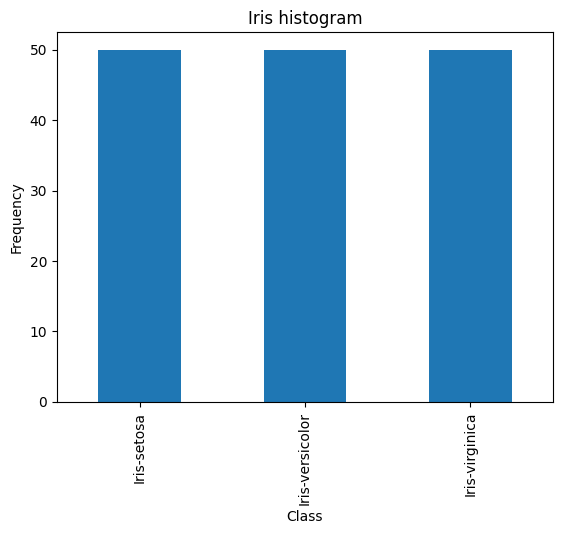

In [41]:
count_classes = pd.value_counts(data['class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Iris histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

The classes are equally distributed so there are no class imbalance problems, which indicates that is a good dataset. Firstly, we initialize the Tree:

In [42]:
dTree = DecisionTree(max_depth=5)

Then we train it:

In [43]:
dTree.fit(Iris.train, Iris.columns)              #training data is an attribute of Data

After that, we predict:

In [44]:
final_results = []
sum = 0
for row in Iris.test:
    #print("row_test: ", row)
    if dTree.predict(row) == row[-1]: # everytime the prediction is equal to the test in each row of the dataset we increment the counter 
        sum += 1
        
print('Number of right predictions: %d/%d' % (sum,len(Iris.test)))
# final_results.append(sum/len(Iris.test)* 100)


Number of right predictions: 42/45


In [45]:
from sklearn.metrics import classification_report

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Collect predictions and true labels
for row in Iris.test:
    true_labels.append(row[-1])
    predicted_labels.append(dTree.predict(row))

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=[str(cls) for cls in np.unique(true_labels)])

# Print the classification report
print('Classification Report:')
print(report)

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.93      0.87      0.90        15
 Iris-virginica       0.88      0.93      0.90        15

       accuracy                           0.93        45
      macro avg       0.93      0.93      0.93        45
   weighted avg       0.93      0.93      0.93        45



In [46]:
print(dTree.print_tree())

<petallength> <= 1.9

      Iris-setosa (2)

<petallength> > 1.9

      <petalwidth> <= 1.7

              <petallength> <= 5.0

                      <sepallength> <= 4.9

                              Iris-virginica (6)

            <sepallength> > 4.9

                              Iris-versicolor (7)

        <petallength> > 5.0

                      Iris-virginica (8)

    <petalwidth> > 1.7

              <petallength> <= 4.8

                      <sepallength> <= 5.9

                              Iris-versicolor (11)

            <sepallength> > 5.9

                              Iris-virginica (12)

        <petallength> > 4.8

                      Iris-virginica (13)


## **Restaurant**

The Restaurant dataset contains information about customers and
restaurants (type of food, waiting time, price etc), and the class attribute (last column) says if
the customer will wait or not to eat in that restaurant. The task is to generate a decision tree (as
explained in theoretical class and following the ID3 algorithm available in the textbook). This
decision tree must be used later to classify (answer if the customer will wait or not) new cases.


In [47]:
restaurant_data = pd.read_csv('datasets/restaurant(1).csv')
Restaurant = Data(restaurant_data, 0.3) 

     ID  Alt  Bar  Fri  Hun   Pat Price Rain  Res     Type    Est Class
0    X1  Yes   No   No  Yes  Some   $$$   No  Yes   French   0-10   Yes
1    X2  Yes   No   No  Yes  Full     $   No   No     Thai  30-60    No
2    X3   No  Yes   No   No  Some     $   No   No   Burger   0-10   Yes
3    X4  Yes   No  Yes  Yes  Full     $   No   No     Thai  10-30   Yes
4    X5  Yes   No  Yes   No  Full   $$$   No  Yes   French    >60    No
5    X6   No  Yes   No  Yes  Some    $$  Yes  Yes  Italian   0-10   Yes
6    X7   No  Yes   No   No   NaN     $  Yes   No   Burger   0-10    No
7    X8   No   No   No  Yes  Some    $$  Yes  Yes     Thai   0-10   Yes
8    X9   No  Yes  Yes   No  Full     $  Yes   No   Burger    >60    No
9   X10  Yes  Yes  Yes  Yes  Full   $$$   No  Yes  Italian  10-30    No
10  X11   No   No   No   No   NaN     $   No   No     Thai   0-10    No
11  X12  Yes  Yes  Yes  Yes  Full     $   No   No   Burger  30-60   Yes


**0.7**

/var/folders/fc/yhkk1bks6bs2m74lnp9spqhw0000gn/T/ipykernel_8600/420002248.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(restaurant_data['Class'], sort = True).sort_index()


Text(0, 0.5, 'Frequency')

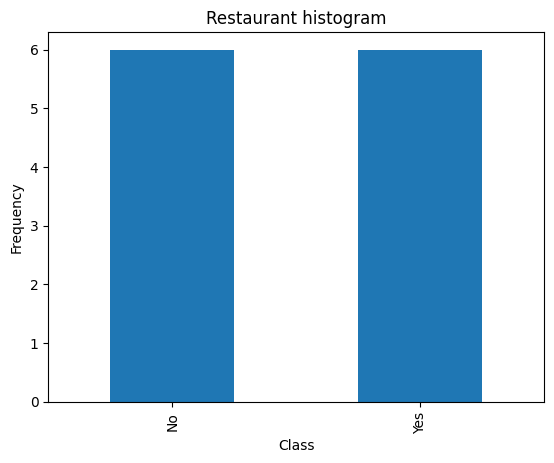

In [48]:
count_classes = pd.value_counts(restaurant_data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Restaurant histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")


In [49]:
dTree = DecisionTree(max_depth=5)

In [50]:
dTree.fit(Restaurant.train, Restaurant.columns)              #training data is an attribute of Data

In [51]:
sum = 0
for row in Restaurant.test:
    #print("row_test: ", row)
    if dTree.predict(row) == row[-1]: # everytime the prediction is equal to the test in each row of the dataset we increment the counter 
        sum += 1
        
print('Number of right predictions: %d/%d' % (sum,len(Restaurant.test)))
# final_results.append(sum/len(Restaurant.test) *100)

Number of right predictions: 1/2


In [52]:
print(dTree.print_tree())


<Pat>

  Full: 
    <Est>

      10-30:         Yes (3)

      30-60: 
        <Bar>

          Yes:             Yes (5)

          No:             No (6)

      >60:         No (7)

  Some:     Yes (8)

  Empty:     No (9)


## **Weather**

The Weather dataset contains information about climate conditions to play tennis. The task is to learn a
decision tree that can decide what are the best conditions to play tennis.

In [53]:
weather_data = pd.read_csv('datasets/weather.csv')

Weather = Data(weather_data, 0.3) #we create an instance of class Data and we indicate the split is 0.3 for test data 
#then we can visualize the data 

    ID   Weather  Temp  Humidity  Windy Play
0    1     sunny    85        85  False   no
1    2     sunny    80        90   True   no
2    3  overcast    83        86  False  yes
3    4     rainy    70        96  False  yes
4    5     rainy    68        80  False  yes
5    6     rainy    65        70   True   no
6    7  overcast    64        65   True  yes
7    8     sunny    72        95  False   no
8    9     sunny    69        70  False  yes
9   10     rainy    75        80  False  yes
10  11     sunny    75        70   True  yes
11  12  overcast    72        90   True  yes
12  13  overcast    81        75  False  yes
13  14     rainy    71        91   True   no


As we can see most of the attributes are strings (categorical) therefore they use our categorical information gain.

/var/folders/fc/yhkk1bks6bs2m74lnp9spqhw0000gn/T/ipykernel_8600/144932004.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(weather_data['Play'], sort = True).sort_index()


Text(0, 0.5, 'Frequency')

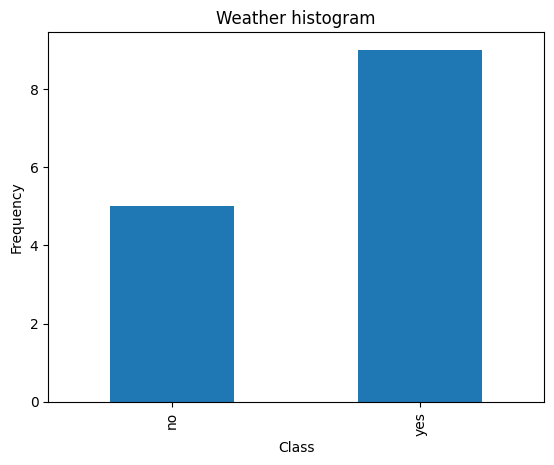

In [54]:
count_classes = pd.value_counts(weather_data['Play'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Weather histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [55]:
dTree = DecisionTree(max_depth=5)

In [56]:
dTree.fit(Weather.train, Weather.columns)              #training data is an attribute of Data

In [57]:
sum = 0 
for row in Weather.test:
    #print("row_test: ", row)
    if dTree.predict(row) == row[-1]: # everytime the prediction is equal to the test in each row of the dataset we increment the counter 
        sum += 1
        
print('Number of right predictions: %d/%d' % (sum,len(Weather.test)))
# final_results.append(sum/len(Weather.test) * 100)


Number of right predictions: 1/3


In [58]:
print(dTree.print_tree())

<Humidity> <= 80

      yes (2)

<Humidity> > 80

  
    <Weather>

      sunny:         no (4)

      overcast:         yes (5)

      rainy:         no (6)


## **Connect-4**

This datasets contains all the combinations of the board of Connect-4 game.

In [59]:
connect4_data = pd.read_csv('datasets/connect4.csv')
Connect4 = Data(connect4_data, 0.2) 

       b b.1 b.2 b.3 b.4 b.5 b.6 b.7 b.8 b.9  ... b.25 b.26 b.27 b.28 b.29  \
0      b   b   b   b   b   b   b   b   b   b  ...    b    b    b    b    b   
1      b   b   b   b   b   b   o   b   b   b  ...    b    b    b    b    b   
2      b   b   b   b   b   b   b   b   b   b  ...    b    b    b    b    b   
3      o   b   b   b   b   b   b   b   b   b  ...    b    b    b    b    b   
4      b   b   b   b   b   b   b   b   b   b  ...    b    b    b    o    b   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...   
67551  x   x   b   b   b   b   o   x   o   b  ...    b    b    b    o    o   
67552  x   x   b   b   b   b   o   b   b   b  ...    b    b    b    o    x   
67553  x   x   b   b   b   b   o   o   b   b  ...    b    b    b    o    x   
67554  x   o   b   b   b   b   o   b   b   b  ...    b    b    b    o    x   
67555  x   o   o   o   x   b   o   b   b   b  ...    b    b    b    x    b   

      b.30 b.31 b.32 b.33   win  
0        b    b    b    b   w

All the instances here are strings.

Text(0, 0.5, 'Frequency')

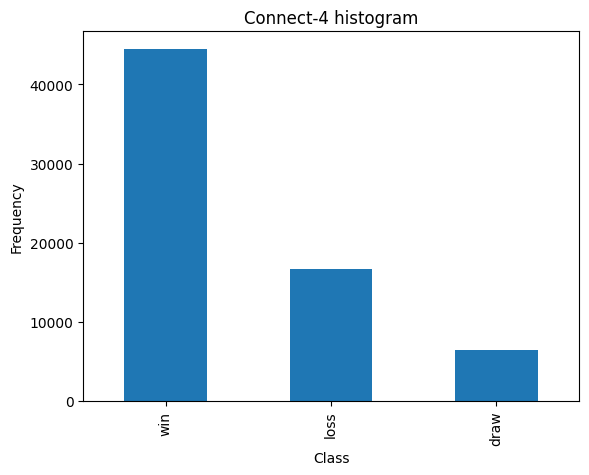

In [60]:
Class = connect4_data.iloc[:, -1]
count_classes = Class.value_counts()
count_classes.plot(kind = 'bar')
plt.title("Connect-4 histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [61]:
dTree = DecisionTree(max_depth=5)

In [62]:
dTree.fit(Connect4.train, Connect4.columns)              #training data is an attribute of DatadTree.fit(Weather.train)              #training data is an attribute of Data

In [63]:
sum = 0 
for row in Connect4.test:
    #print("row_test: ", row)
    if dTree.predict(row) == row[-1]: # everytime the prediction is equal to the test in each row of the dataset we increment the counter 
        sum += 1
        
print('Number of right predictions: %d/%d' % (sum,len(Connect4.test)))
# final_results.append(sum/len(Connect4.test) * 100)


Number of right predictions: 9771/13510


In [64]:
print(dTree.print_tree())


<b.1>

  x: 
    <o.1>

      x: 
        <o.2>

          x: 
            <x.3>

              x: 
                <b.12>

                  o:                     win (6)

                  b:                     win (7)

              o: 
                <x.2>

                  x:                     win (9)

                  o:                     win (10)

              b: 
                <b.12>

                  x:                     win (12)

                  o:                     win (13)

                  b:                     win (14)

          o: 
            <o>

              x: 
                <b.29>

                  x:                     loss (17)

                  o:                     win (18)

                  b:                     loss (19)

              o: 
                <x.2>

                  x:                     loss (21)

                  o:                     loss (22)

              b: 
                <b.2>

                  x:    

## **Menu**

We created a menu were you can choose which tree you want to see, test the decision tree selected and predict unlabeled data with that same three.

In [65]:
# def printTreeOptions():
#     print()
#     print("Select a Decision Tree:")
#     print("1.Iris Tree")
#     print("2.Restaurant Tree")
#     print("3.Connect4 Tree")
#     print("4.Weather Tree")
#     print()
#     print("0.Get back to menu")
    
# def testTree(dataset: Data):
#     print(dataset.name, "tree precision:", dataset.testPedict())
    
# def getAndPredictInput(dataset: Data):
#     toPrint = "Please insert the following data separated by empty spaces "+str(dataset.columns[0])+":\n"
#     x = input(toPrint).split(" ")
#     for i in range(len(x)):
#         x[i] = dataset.columns[1][i](x[i])
#     return dataset.tree.predict(x)


# # usig the entire dataset to train the decision tree
# iris = Data(pd.read_csv("datasets/iris.csv"), 0.0, "iris")
# restaurant = Data(pd.read_csv("datasets/restaurant(1).csv"), 0.0, "restaurant(1)")
# connect4 = Data(pd.read_csv("datasets/connect4.csv"), 0.0, "connect4")
# weather = Data(pd.read_csv("datasets/weather.csv"), 0.0, "weather")

# menuSelect = 0
# secondaryMenuSelect = 0

# while True:
#     if menuSelect == 0:     # Menu
#         secondaryMenuSelect = 0
#         print()
#         print("Select an Operation:")
#         print("1.See Decision Tree")
#         print("2.Test Decision Tree")
#         print("3.Predict my own data with Tree")
#         print("4.Exit")
#         menuSelect = int(input())
#         if (menuSelect > 4 or menuSelect < 0):
#             menuSelect = 0
#             continue
#         continue
#     elif menuSelect == 1:   # Print a Decision Tree
#         printTreeOptions()
#         secondaryMenuSelect = int(input())
        
#         if (secondaryMenuSelect > 4 or secondaryMenuSelect < 0):
#             secondaryMenuSelect = 0
#             continue
#         if secondaryMenuSelect == 0:
#             menuSelect = 0
#             continue
        
#         if secondaryMenuSelect == 1:    # Iris
#             print(iris.tree.print_tree())
#         elif secondaryMenuSelect == 2:  # Restaurant
#             print(restaurant.tree.print_tree())
#         elif secondaryMenuSelect == 3:  # Connect4
#             print(connect4.tree.print_tree())
#         else:                           # Weather
#             print(weather.tree.print_tree())

#     elif menuSelect == 2:   # Test a Decision Tree using the testing data from the csv file

#         # train / test split = 0.7 / 0.3
#         iris = Data(pd.read_csv("datasets/iris.csv"), 0.3, "iris")
#         restaurant = Data(pd.read_csv("datasets/restaurant(1).csv"), 0.3, "restaurant(1)")
#         connect4 = Data(pd.read_csv("datasets/connect4.csv"), 0.3, "connect4")
#         weather = Data(pd.read_csv("datasets/weather.csv"), 0.3, "weather")

#         printTreeOptions()
#         secondaryMenuSelect = int(input())
        
#         if (secondaryMenuSelect > 4 or secondaryMenuSelect < 0):
#             secondaryMenuSelect = 0
#             continue
#         if secondaryMenuSelect == 0:
#             menuSelect = 0
#             continue

#         if secondaryMenuSelect == 1:    # Iris
#             testTree(iris)
#         elif secondaryMenuSelect == 2:  # Restaurant
#             testTree(restaurant)
#         elif secondaryMenuSelect == 3:  # Connect4
#             testTree(connect4)
#         else:                           # Weather
#             testTree(weather)

#     elif menuSelect == 3:   # Insert data and get a prediction from one of the Decision Trees
#         printTreeOptions()
#         secondaryMenuSelect = int(input())
        
#         if (secondaryMenuSelect > 4 or secondaryMenuSelect < 0):
#             secondaryMenuSelect = 0
#             continue
#         if secondaryMenuSelect == 0:
#             menuSelect = 0
#             continue
        
#         if secondaryMenuSelect == 1:    # Iris
#             print(getAndPredictInput(iris))
#         elif secondaryMenuSelect == 2:  # Restaurant
#             print(getAndPredictInput(restaurant))
#         elif secondaryMenuSelect == 3:  # Connect4
#             print(getAndPredictInput(connect4))
#         else:                           # Weather
#             print(getAndPredictInput(weather))

#     elif menuSelect == 4:   # Exit the program
#         break

# **Conclusion**

We created a Induced ID3 Decision Tree Algorithm that can classify both categorical and numerical values and predict a unlabeled instance of the dataset. We also made a class Data to pre-process all the data and do the intended splits. We obtained very good results, since all our right previsions are at least above 70%. 

In [66]:
# # Generate a sequence of dataset indices
# datasets = np.arange(1, len(final_results) + 1)

# # Create a plot
# plt.figure(figsize=(10, 6))
# plt.plot(datasets, final_results, marker='o', linestyle='-', color='b')

# # Add labels and title
# plt.xlabel('Dataset Index')
# plt.ylabel('Accuracy')
# plt.title('Model Accuracy on Different Datasets')

# # Add grid for better readability
# plt.grid(True)

# # Display the plot
# plt.show()

In [109]:
from connect_four import Board
import random

In [131]:
game = Board()
print(game)
children = game.possibleMoves() # list of possible columns to make the next play
for i in range(len(children)):
    print(children[i])

.......
.......
.......
.......
.......
.......

1
2
3
4
5
6
7


In [116]:
initial_state = TreeNode(value=game.board)
print(initial_state)

Index: None
Value: [['.', '.', '.', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', '.']]Label:None
Children:None


In [119]:
# def transform_connect_four_to_dataset(state):
#     resp=""
#     linha=0
#     coluna=0
#     for i in range (42):
#         if linha == 6:
#             linha = 0
#             coluna += 1
#         if state[5-linha][coluna] == '.':
#             state[5-linha][coluna] = 'b'
#         elif state[5-linha][coluna] == 'X':
#             state[5-linha][coluna] = 'x'
#         elif state[5-linha][coluna] == 'O':
#             state[5-linha][coluna] = 'o'

#         resp = resp + state[5-linha][coluna] + ","
#         linha+=1
        
#     resp = resp.rstrip(',')
#     return resp
# # tranformar o tabuleiro em csv

# transform_connect_four_to_dataset(game.board)

'b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b'

In [141]:
def get_wins(state):
    for i in range(len(children)):
        state.move(i, state.turn)
        print(state)
    
get_wins(game)

.O.....
XXOXOX.
OXOXOX.
OXOXOX.
OOOXOX.
XOXOXO.

OO.....
XXOXOX.
OXOXOX.
OXOXOX.
OOOXOX.
XOXOXO.

OO.....
XXOXOX.
OXOXOX.
OXOXOX.
OOOXOX.
XOXOXO.

OOX....
XXOXOX.
OXOXOX.
OXOXOX.
OOOXOX.
XOXOXO.

OOXO...
XXOXOX.
OXOXOX.
OXOXOX.
OOOXOX.
XOXOXO.

OOXOX..
XXOXOX.
OXOXOX.
OXOXOX.
OOOXOX.
XOXOXO.

OOXOXO.
XXOXOX.
OXOXOX.
OXOXOX.
OOOXOX.
XOXOXO.



In [139]:
print(game.board)
game.move(2, 2)

[['X', 'O', 'X', 'O', 'X', 'O', '.'], ['O', 'O', 'O', 'X', 'O', 'X', '.'], ['O', 'X', 'O', 'X', 'O', 'X', '.'], ['O', 'X', 'O', 'X', 'O', 'X', '.'], ['.', 'X', '.', '.', '.', '.', '.'], ['.', '.', '.', '.', '.', '.', '.']]


True

In [ ]:
def predict_move_tree(dt,state):
    
    print("Estado: ",state)
    
    sucessores, cols = state.successors()

    movimentos=[]

    for i in range(len(sucessores)):
        
        if sucessores[i] is None:
            continue
                
        resp=transform_connect_four_to_dataset(sucessores[i].board)
        
        dt = predict_new_example(dt, resp)
        previsao = prever_dataset(dt, tree)
        previsao_final = previsao[len(previsao) - 1]
        if previsao_final == "win":
            movimentos.append(cols[i])

    if movimentos == []:
        possible_moves = [col for col in range(7) if not state.is_full(col)]
        if possible_moves:
            random_move = random.choice(possible_moves)  # Escolhe um movimento possível aleatório
            state.move(random_move, state.turn)
    else:
        state.move(random.choice(movimentos), state.turn)
        
        

game=Board()

game.board = [["-"] * 7 for _ in range(6)]


while not (game.winner or game.is_board_full()):
    if game.turn=="X":
        predict_move_tree(dt,game)
    else:
        alpha = float('-inf')
        beta = float('inf')
                    
        _,prox_move=game.alphabeta(5,alpha,beta,1)
        game.move(prox_move,game.turn)
    
        game.check_winner()
        print (game)


if game.winner:
    print("Game Over! Player", game.player_winner, "wins!!")
else:
    print("Game Over! It's a draw")
   